In [1]:
# Import necessary libraries
import pandas as pd
from pandas_datareader import data
import yfinance as yf

# Overriding the Yahoo Finance data reader
yf.pdr_override()

In [2]:
def load_financial_data_multi(tickers, start_date, end_date):
    """
    Function to load the stock OHLC price in the list of tickers from `start_date` to `end_date
    """
    # Define the output file name
    output_file = 'data_'+tickers[0]+'_etc_'+start_date+'_'+end_date+'.pkl'
    try:
        # Try to read the data from the output file
        df = pd.read_pickle(output_file)
        # If the data is already downloaded, print a success message
        print('File data found...reading '+tickers[0]+' etc data')
    except FileNotFoundError:
        # If the file is not found, download the data from Yahoo Finance
        print('File not found...downloading the '+tickers[0]+' etc data')
        # Download the data
        df = data.get_data_yahoo(tickers, start_date, end_date)
        # Save the data to the output file
        df.to_pickle(output_file)
    # Return the requested data
    return df

In [3]:
# Define the start date
start_date = '2020-01-01'
# Define the end date
end_date = '2024-03-31'
# Define the trading instrument with prices in CAD and USD
trading_instrument = 'CADUSD=X'
# Define a list of tickers with prices in other currencies and USD
tickers = ['AUDUSD=X', 'GBPUSD=X', 'CADUSD=X', 'CHFUSD=X', 'EURUSD=X', 'JPYUSD=X', 'NZDUSD=X']

# Load the data
data=load_financial_data_multi(tickers, start_date, end_date)
# Define the Forex data
FX_data = data.swaplevel("Price", "Ticker", 1)

File data found...reading AUDUSD=X etc data


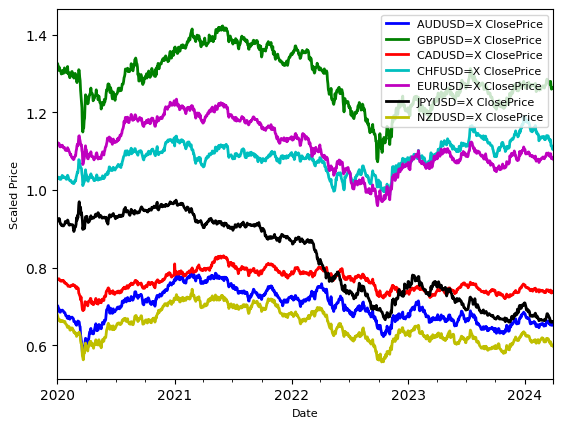

In [4]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

# Create a cyclic iterator that cycles around bgrcmky for colors
cycol = cycle('bgrcmky')

# Create a dataframe to store the price data
price_data = pd.DataFrame()
# Iterate though the predefined tickers
for FX in tickers:
    # Initialize the multipler factor
    multiplier = 1.0
    # If the ticker is between JPY and USD
    if FX == 'JPYUSD=X':
        # Set the multiplier to 100
        multiplier = 100.0

    # Define the label for plotting
    label = FX + ' ClosePrice'
    # Create a new column called `label` conisting of the closing price of the current ticker
    price_data = price_data.assign(label=pd.Series(FX_data[FX]['Close'] * multiplier, index=FX_data[FX].index))
    # Plot the closing price with the color palette defined above
    ax = price_data['label'].plot(color=next(cycol), lw=2., label=label)

# Set the x-axis' label
plt.xlabel('Date', fontsize=8)
# Set the y-axis' label
plt.ylabel('Scaled Price', fontsize=8)
# Show the legend with a size of 8
plt.legend(prop={'size': 8})
# Show the plot
plt.show()

In [5]:
# Import the library to do statistics
import statistics as stats

# Define the number of look back periods in simple moving averange (SMA)
SMA_NUM_PERIODS = 20
# Initialize the historical price
price_history = {}

# Define the number of look back periods for the deviation between the price and the SMA
PRICE_DEV_NUM_PRICES = 200
# Initialize the deviation between the price and SMA
price_deviation_from_sma = {}

# Get the total number of days in the data
num_days = len(FX_data[trading_instrument].index)
# Initialize the historical correlation among the tickers
correlation_history = {}
# Initialize the historical differences between the projected close price deviation and the actual close price deviation
delta_projected_actual_history = {}
# Initialize the historical differences between the final projected close price deviation of the current `trading_instrument` and the actual close price deviation
final_delta_projected_history = []

In [6]:
# Initialize a list to store the buy/sell signals
orders = []
# Initialize a list to store the position over time
positions = []
# Initialize a list to store the total PnLs (Profit and Loss)
pnls = []

# To store the last buy price
last_buy_price = 0
# To store the last sell price
last_sell_price = 0
# To store the current position
position = 0
# To store the current sum of buy quantities (considering the price)
buy_sum_price_qty = 0
# To store the current sum of buy quantities (just the quantities)
buy_sum_qty = 0
# To store the current sum of sell quantities (considering the price)
sell_sum_price_qty = 0
# To store the current sum of sell quantities (just the quantities)
sell_sum_qty = 0
# To store the current open pnl
open_pnl = 0
# To store the current closed pnl
closed_pnl = 0

# Define the threshold for the trading signal to enter long position
StatArb_VALUE_FOR_BUY_ENTRY = 0.01
# Define the threshold for the trading signal to enter short position
StatArb_VALUE_FOR_SELL_ENTRY = -0.01
# Define the minimum price change since last trade
MIN_PRICE_MOVE_FROM_LAST_TRADE = 0.01
# Define the number of currency to buy or sell on each trade
NUM_SHARES_PER_TRADE = 1000000
# Define the minimum prifit to close the position and take profit
MIN_PROFIT_TO_CLOSE = 10

In [7]:
# Iterate through historical timestamps
for i in range(0, num_days):
    # Initialize the closing price
    close_prices = {}

    # Iterate though the pre-defined list of tickers
    for ticker in tickers:
        # Store the closing price for the current ticker
        close_prices[ticker] = FX_data[ticker]['Close'].iloc[i]
        # If the current ticker is not stored in the historical price yet
        if not ticker in price_history.keys():
            # Initialize a place in memory for that ticker (actually, why don't we use defaultdict?)
            price_history[ticker] = []
            # Initialize the price deviation between the price and SMA
            price_deviation_from_sma[ticker] = []

        # Add the closing price to the historical price
        price_history[ticker].append(close_prices[ticker])
        # If the current length of the historical price exceeds the look back periods of SMA
        if len(price_history[ticker]) > SMA_NUM_PERIODS:
            # We remove the earliest one since it's no longer considered
            del (price_history[ticker][0])

        # Calculate the SMA
        sma = stats.mean(price_history[ticker])
        # Calculate and store the price deviation between the closing price and the SMA
        price_deviation_from_sma[ticker].append(close_prices[ticker] - sma)
        # If the current length of the devation between the closing price and the SMA exceeds the pre-defined look back
        if len(price_deviation_from_sma[ticker]) > PRICE_DEV_NUM_PRICES:
            # Delete the earliest one sice it's no longer considered
            del (price_deviation_from_sma[ticker][0])

    # Inititialize the projected price deviation using tickers
    projected_dev_from_sma_using = {}
    # Iterate through the list of tickers to find the covariance and correlation between `trading_instrument` and other tickers
    for ticker in tickers:
        # There is no need to find the relationship between the considering instrument with itself
        if ticker == trading_instrument:
            # We skip
            continue

        # Define the correlation label between the considering instrument and the current ticker
        correlation_label = trading_instrument + '<-' + ticker
        # If the label is not encountered before
        if correlation_label not in correlation_history.keys():
            # Initialize a place in memory for that pair (seriously, why don't we use defaultdict???)
            correlation_history[correlation_label] = []
            # Initialize the historical differences between the projected close price deviation and the actual close price deviation of the current pair
            delta_projected_actual_history[correlation_label] = []

        # We need at least 3 data points to compute the correlation (actually, we just need at least 2, idk why professor put three here)
        # Maybe because of the fact that only with just 2 data points will result in the correlation coefficient  of either 1 or -1, not giving much information
        if len(price_deviation_from_sma[ticker]) < 2:
            # Default correlation is 0
            correlation_history[correlation_label].append(0)
            # Default historical delta_projected_actual is 0
            delta_projected_actual_history[correlation_label].append(0)
            # We skip
            continue
        
        # Compute the correlation matrix between the `trading_instrument` and the current ticker
        corr = np.corrcoef(price_deviation_from_sma[trading_instrument], price_deviation_from_sma[ticker])
        # Calculate the covariance matrix between the `trading_instrument` and the current ticker
        cov = np.cov(price_deviation_from_sma[trading_instrument], price_deviation_from_sma[ticker])

        # Get the actual correlation between trading_instrument` and the current ticker
        corr_trading_instrument_lead_instrument = corr[0, 1]
        # Get the actual covariance between trading_instrument` and the current ticker
        cov_trading_instrument_lead_instrument = cov[0, 0] / cov[0, 1]

        # Store the correlation 
        correlation_history[correlation_label].append(corr_trading_instrument_lead_instrument)

        # Calculate the projected deviation from the SMA
        # It would equal to covariance * last_price_deviation
        projected_dev_from_sma_using[ticker] = price_deviation_from_sma[ticker][-1] * cov_trading_instrument_lead_instrument

        # Calculate the difference between projected and actual deviation
        delta_projected_actual = (projected_dev_from_sma_using[ticker] - price_deviation_from_sma[trading_instrument][-1])
        # Store the the difference between projected and actual deviation
        delta_projected_actual_history[correlation_label].append(delta_projected_actual)


    # Define the total weights
    sum_weights = 0
    # Iterate through the list of tickers
    for ticker in tickers:
        # No need to compute relation between `trading_instrument` and itself
        if ticker == trading_instrument:
            # We skip
            continue
        
        # Get the correlation label
        correlation_label = trading_instrument + '<-' + ticker
        # Update the total weights by adding the last correlation coefficient of the pair
        sum_weights += abs(correlation_history[correlation_label][-1])

    # Define the final prediction of price deviation
    final_delta_projected = 0
    # Initialize the closing price
    close_price = close_prices[trading_instrument]
    # Iterate through the list of tickers
    for ticker in tickers:
        # No need to compute relation between `trading_instrument` and itself
        if ticker == trading_instrument:
            # Skipping
            continue
        
        # Get the correlation label
        correlation_label = trading_instrument + '<-' + ticker
        # Update the final prediction
        # Weight projection from a ticker by its correlation with the `trading_instrument`
        final_delta_projected += (abs(correlation_history[correlation_label][-1]) * delta_projected_actual_history[correlation_label][-1])

    # If the sum of the weight is non-zero
    if sum_weights != 0:
        # We normalize the sum, making it our final prediction
        final_delta_projected /= sum_weights
    else:
        # Otherwise, set it to 0
        final_delta_projected = 0

    # Save the final prediction
    final_delta_projected_history.append(final_delta_projected)

    # If the final prediction is below the selling threshold and the price movement from the last sell action is more than the pre-defined minmum price movement from last trade
    # Or we are having long position and it is profitable enough based on the minimum profit to close position
    if ((final_delta_projected < StatArb_VALUE_FOR_SELL_ENTRY and abs(close_price - last_sell_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE)  \
        or (position > 0 and (open_pnl > MIN_PROFIT_TO_CLOSE))):
        # We sell
        orders.append(-1)
        # Update the last sell price
        last_sell_price = close_price
        # The position is reduced by the number of sold shares
        position -= NUM_SHARES_PER_TRADE
        # Update the current sum of sell quantities (considering the price)
        sell_sum_price_qty += (close_price * NUM_SHARES_PER_TRADE)
        # Update the current sum of sell quantities (just the quantities)
        sell_sum_qty += NUM_SHARES_PER_TRADE
        # Print the sell action
        print("Sell ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position)
        # Print the PnL information
        print("OpenPnL: ", open_pnl, " ClosedPnL: ", closed_pnl, " TotalPnL: ", (open_pnl + closed_pnl))

    # If the final prediction exceeds the buying threshold and the price movement from the last sell action is more than the pre-defined minmum price movement from last trade
    # Or we are having short position and it is profitable enough based on the minimum profit to close position
    elif ((final_delta_projected > StatArb_VALUE_FOR_BUY_ENTRY and abs(close_price - last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE) \
          or (position < 0 and (open_pnl > MIN_PROFIT_TO_CLOSE))):
        # We buy
        orders.append(+1)
        # Update the last buy price
        last_buy_price = close_price
        # The position is increased by the number of sold shares
        position += NUM_SHARES_PER_TRADE
        # Update the current sum of buy quantities (considering the price)
        buy_sum_price_qty += (close_price * NUM_SHARES_PER_TRADE)
        # Update the current sum of buy quantities (just the quantities)
        buy_sum_qty += NUM_SHARES_PER_TRADE
        # Print the buy action
        print("Buy ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position)
        # Print the PnL information
        print("OpenPnL: ", open_pnl, " ClosedPnL: ", closed_pnl, " TotalPnL: ", (open_pnl + closed_pnl))
    
    # Otherwise
    else:
        # We don't trade
        orders.append(0)

    # Save the current position
    positions.append(position)

    # Initialize the open PnL
    open_pnl = 0
    # If we are having long position
    if position > 0:
        # And we have some sell trades have been made against it
        if sell_sum_qty > 0:
            # Close that amount based on how much was sold against this long position
            open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty / sell_sum_qty - buy_sum_price_qty / buy_sum_qty)
        # Mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
        open_pnl += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
    # If we are having short position
    elif position < 0:
        # And we have some buy trades have been made against it
        if buy_sum_qty > 0:
            # Close that amount based on how much was sold against this long position
            open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty / sell_sum_qty - buy_sum_price_qty / buy_sum_qty)
        # Mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
        open_pnl += abs(buy_sum_qty - position) * (sell_sum_price_qty / sell_sum_qty - close_price)
    # If we are having no position
    else:
        # Update the closing PnL
        closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
        # Reset the current sum of buy quantities (considering the price)
        buy_sum_price_qty = 0
        # Reset the current sum of buy quantities (jsut the quantities)
        buy_sum_qty = 0
        # Reset the current sum of sell quantities (considering the price)
        sell_sum_price_qty = 0
        # Reset the current sum of sell quantities (jsut the quantities)
        sell_sum_qty = 0
        # Reset the last buy price
        last_buy_price = 0
        # Reset the last sell price
        last_sell_price = 0

    # Store the total PnL
    pnls.append(closed_pnl + open_pnl)

/home/duc/anaconda3/envs/trading/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/duc/anaconda3/envs/trading/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_917416/3799202478.py:69: RuntimeWarning: divide by zero encountered in scalar divide
  cov_trading_instrument_lead_instrument = cov[0, 0] / cov[0, 1]
/tmp/ipykernel_917416/3799202478.py:76: RuntimeWarning: invalid value encountered in scalar multiply
  projected_dev_from_sma_using[ticker] = price_deviation_from_sma[ticker][-1] * cov_trading_instrument_lead_instrument


Sell  1000000  @  0.7545062899589539 Position:  -1000000
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
Buy  1000000  @  0.7545461654663086 Position:  0
OpenPnL:  347.0778465270996  ClosedPnL:  0  TotalPnL:  347.0778465270996
Sell  1000000  @  0.7458734512329102 Position:  -1000000
OpenPnL:  0  ClosedPnL:  -39.87550735473633  TotalPnL:  -39.87550735473633
Buy  1000000  @  0.7321715950965881 Position:  0
OpenPnL:  11777.639389038086  ClosedPnL:  -39.87550735473633  TotalPnL:  11737.76388168335
Sell  1000000  @  0.7172160744667053 Position:  -1000000
OpenPnL:  0  ClosedPnL:  13661.980628967285  TotalPnL:  13661.980628967285
Buy  1000000  @  0.7022866010665894 Position:  0
OpenPnL:  3470.778465270996  ClosedPnL:  13661.980628967285  TotalPnL:  17132.75909423828
Buy  1000000  @  0.689740777015686 Position:  1000000
OpenPnL:  0  ClosedPnL:  28591.454029083252  TotalPnL:  28591.454029083252
Sell  1000000  @  0.6915916204452515 Position:  0
OpenPnL:  0.0  ClosedPnL:  28591.454029083252  TotalPnL:  

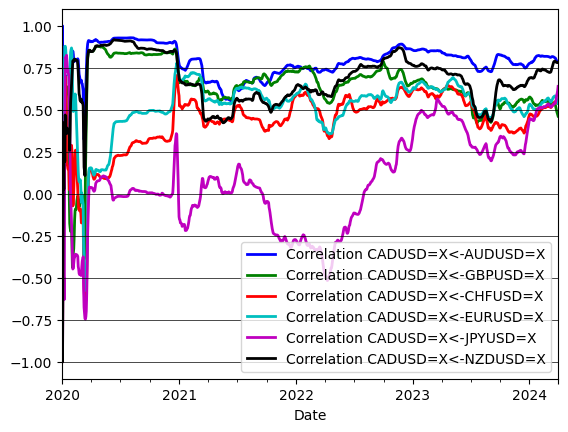

In [8]:
# Initialize the correlation data as a data frame
correlation_data = pd.DataFrame()
# Iterate though the tickers
for ticker in tickers:
    # No need to compute `trading_instrument` with itself
    if ticker == trading_instrument:
        # Skipppppppp
        continue
    
    # Get the correlation label
    correlation_label = trading_instrument + '<-' + ticker
    # Create a column named `label` consisting of the historical correlation between the `trading_instrument` and the current ticker
    correlation_data = correlation_data.assign(label=pd.Series(correlation_history[correlation_label], index=FX_data[ticker].index))
    # Plot the historical correlation
    ax = correlation_data['label'].plot(color=next(cycol), lw=2., label='Correlation ' + correlation_label)

# Plot horizontal lines from -1 to 1 with a distance of 0.25 each
for i in np.arange(-1, 1, 0.25):
    # plot the line
    plt.axhline(y=i, lw=0.5, color='k')
# Show the legend
plt.legend()
# Show the plot
plt.show()

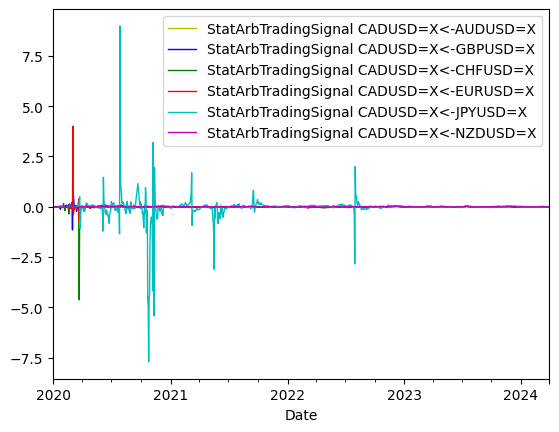

In [9]:
# Initialize the difference between predicted and actual price deviation as a data frame
delta_projected_actual_data = pd.DataFrame()
# Iterate though the tickers
for ticker in tickers:
    # No need to compute `trading_instrument` with itself
    if ticker == trading_instrument:
        # Skipppppppp
        continue
    
    # Get the prediction label
    projection_label = trading_instrument + '<-' + ticker
    # Create a column named `label` consisting of the historical differences between predicted and actual price deviation
    delta_projected_actual_data = delta_projected_actual_data.assign(StatArbTradingSignal=pd.Series(delta_projected_actual_history[projection_label], index=FX_data[trading_instrument].index))
    # Plot the historical differences
    ax = delta_projected_actual_data['StatArbTradingSignal'].plot(color=next(cycol), lw=1., label='StatArbTradingSignal ' + projection_label)
# Show the legend
plt.legend()
# Show the plot
plt.show()

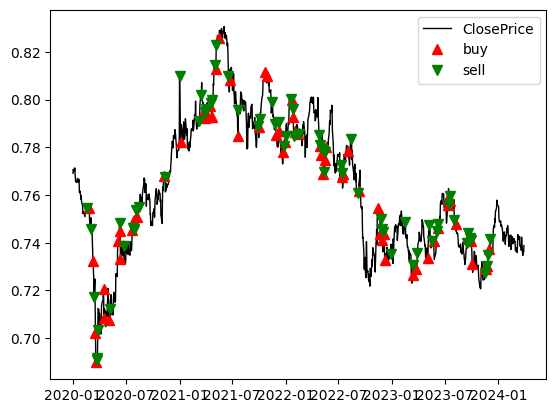

In [10]:
# Create a column named `ClosePrice` consisting of the historical closing price of `trading_instrument`
delta_projected_actual_data = delta_projected_actual_data.assign(ClosePrice=pd.Series(FX_data[trading_instrument]['Close'], index=FX_data[trading_instrument].index))
# Create a column named `FinalStatArbTradingSignal` consisting of the predicted deviation of `trading_instrument`
delta_projected_actual_data = delta_projected_actual_data.assign(FinalStatArbTradingSignal=pd.Series(final_delta_projected_history, index=FX_data[trading_instrument].index))
# Create a column named `Trades` consisting of the buy/sell signals
delta_projected_actual_data = delta_projected_actual_data.assign(Trades=pd.Series(orders, index=FX_data[trading_instrument].index))
# Create a column named `Position` consisting of the positions over time
delta_projected_actual_data = delta_projected_actual_data.assign(Position=pd.Series(positions, index=FX_data[trading_instrument].index))
# Create a column named `Pnl` consisting of the Pnls over time
delta_projected_actual_data = delta_projected_actual_data.assign(Pnl=pd.Series(pnls, index=FX_data[trading_instrument].index))

# Plot the closing price
plt.plot(delta_projected_actual_data.index, delta_projected_actual_data.ClosePrice, color='k', lw=1., label='ClosePrice')
# Plot the buy signal
plt.plot(delta_projected_actual_data.loc[delta_projected_actual_data.Trades == 1].index, delta_projected_actual_data.ClosePrice[delta_projected_actual_data.Trades == 1], color='r', lw=0, marker='^', markersize=7, label='buy')
# Plot the sell signal
plt.plot(delta_projected_actual_data.loc[delta_projected_actual_data.Trades == -1].index, delta_projected_actual_data.ClosePrice[delta_projected_actual_data.Trades == -1], color='g', lw=0, marker='v', markersize=7, label='sell')
# Show the legend
plt.legend()
# Show the plot
plt.show()

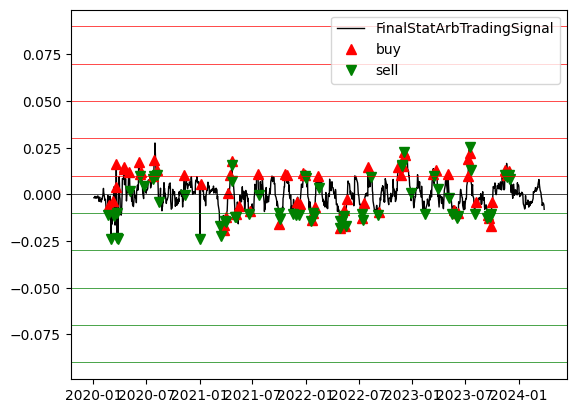

In [11]:
# Plot the predicted deviation
plt.plot(delta_projected_actual_data.index, delta_projected_actual_data.FinalStatArbTradingSignal, color='k', lw=1., label='FinalStatArbTradingSignal')
# Plot the buy signal
plt.plot(delta_projected_actual_data.loc[delta_projected_actual_data.Trades == 1].index, delta_projected_actual_data.FinalStatArbTradingSignal[delta_projected_actual_data.Trades == 1], color='r', lw=0, marker='^', markersize=7, label='buy')
# Plot the sell signal
plt.plot(delta_projected_actual_data.loc[delta_projected_actual_data.Trades == -1].index, delta_projected_actual_data.FinalStatArbTradingSignal[delta_projected_actual_data.Trades == -1], color='g', lw=0, marker='v', markersize=7, label='sell')
# Plot a horizontal line at y=0
plt.axhline(y=0, lw=0.5, color='k')
# Plot horizontal lines from y=Buy threshold to 10x the threshold with a step of 2x threshold
for i in np.arange(StatArb_VALUE_FOR_BUY_ENTRY, StatArb_VALUE_FOR_BUY_ENTRY * 10, StatArb_VALUE_FOR_BUY_ENTRY * 2):
    # Plot the line
    plt.axhline(y=i, lw=0.5, color='r')
# Plot horizontal lines from y=Sell threshold to 10x the threshold with a step of 2x threshold
for i in np.arange(StatArb_VALUE_FOR_SELL_ENTRY, StatArb_VALUE_FOR_SELL_ENTRY * 10, StatArb_VALUE_FOR_SELL_ENTRY * 2):
    # Plot the line
    plt.axhline(y=i, lw=0.5, color='g')
# Show the legend
plt.legend()
# Show the plot
plt.show()

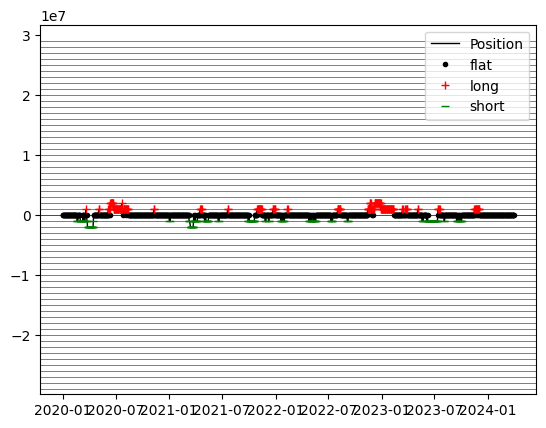

In [12]:
# Plot the positions over time
plt.plot(delta_projected_actual_data.index, delta_projected_actual_data.Position, color='k', lw=1., label='Position')
# Plot the no position indicator
plt.plot(delta_projected_actual_data.loc[delta_projected_actual_data.Position == 0].index, delta_projected_actual_data.Position[delta_projected_actual_data.Position == 0], color='k', lw=0, marker='.', label='flat')
# Plot the long position
plt.plot(delta_projected_actual_data.loc[delta_projected_actual_data.Position > 0].index, delta_projected_actual_data.Position[delta_projected_actual_data.Position > 0], color='r', lw=0, marker='+', label='long')
# Plot the short position
plt.plot(delta_projected_actual_data.loc[delta_projected_actual_data.Position < 0].index, delta_projected_actual_data.Position[delta_projected_actual_data.Position < 0], color='g', lw=0, marker='_', label='short')
# Plot a horizontal line at y=0
plt.axhline(y=0, lw=0.5, color='k')
# Plot horizontal lines from y=Number of shares per trade to 30x the #shares with a step of 1x #shares
for i in range(NUM_SHARES_PER_TRADE, NUM_SHARES_PER_TRADE * 30, NUM_SHARES_PER_TRADE):
    # Plot the line
    plt.axhline(y=i, lw=0.5, color='r')
# Plot horizontal lines from y=-Number of shares per trade to -30x the #shares with a step of -1x #shares
for i in range(-NUM_SHARES_PER_TRADE, -NUM_SHARES_PER_TRADE * 30, -NUM_SHARES_PER_TRADE):
    # Plot the line
    plt.axhline(y=i, lw=0.5, color='g')
# Show the legend
plt.legend()
# Show the plot
plt.show()

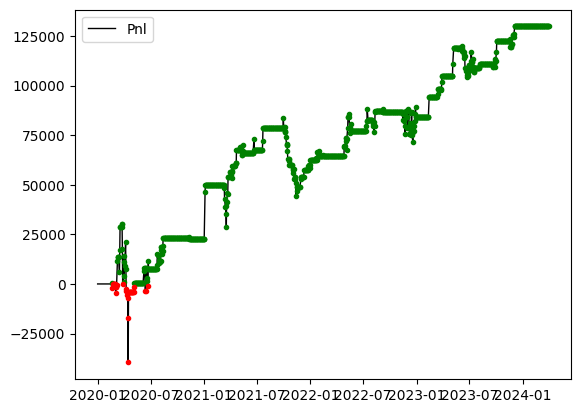

In [13]:
# Plot the PnLs over time
plt.plot(delta_projected_actual_data.index, delta_projected_actual_data.Pnl, color='k', lw=1., label='Pnl')
# Plot the Postitive PnLs
plt.plot(delta_projected_actual_data.loc[delta_projected_actual_data.Pnl > 0].index, delta_projected_actual_data.Pnl[delta_projected_actual_data.Pnl > 0], color='g', lw=0, marker='.')
# Plot the Negative PnLs
plt.plot(delta_projected_actual_data.loc[delta_projected_actual_data.Pnl < 0].index, delta_projected_actual_data.Pnl[delta_projected_actual_data.Pnl < 0], color='r', lw=0, marker='.')
# Show the legend
plt.legend()
# Show the plot
plt.show()